<a href="https://colab.research.google.com/github/clearlakerabbit/ME793_Project/blob/main/ME793_simulation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

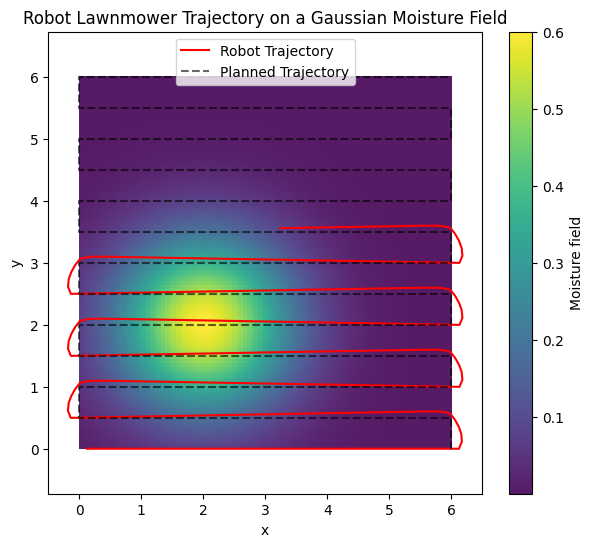

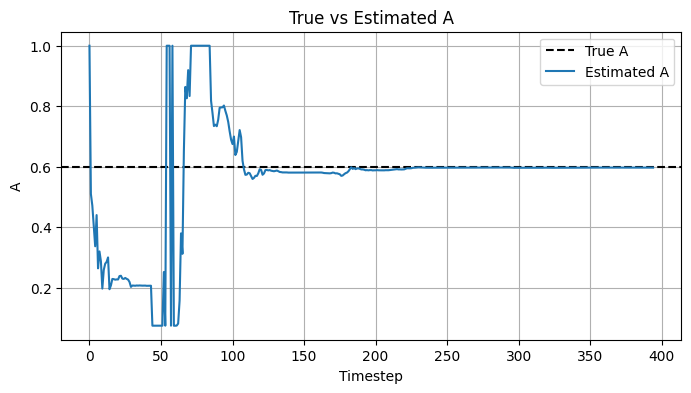

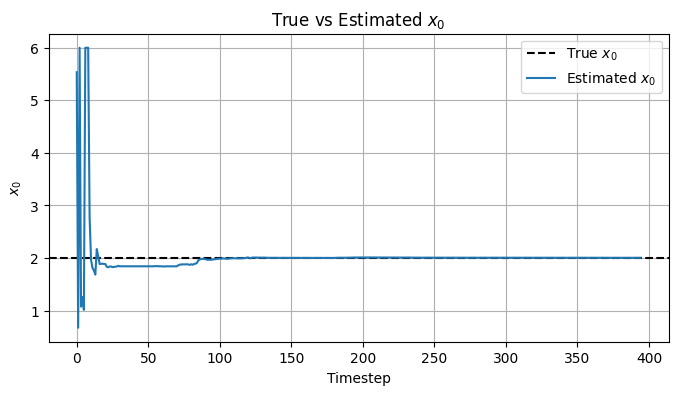

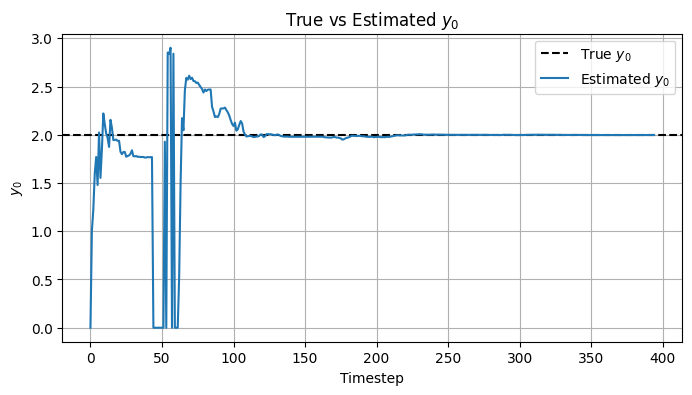

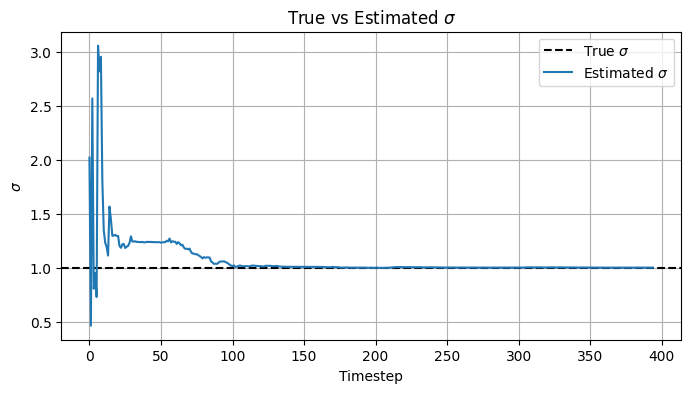

In [32]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import least_squares
import os

# set seed for consistency
np.random.seed(1)

# folder for plots
plot_dir = "plots"
os.makedirs(plot_dir, exist_ok=True)

# true values of Gaussian parameters
A_true, x0_true, y0_true, sigma_true = 0.6, 2.0, 2.0, 1.0

# lawnmower trajectory implemented
field_width, field_height, strip_spacing = 6.0, 6.0, 0.5
dt, v_const = 0.5, 0.25

waypoints = []
y, direction = 0.0, 1
while y <= field_height:
    if direction == 1:
        waypoints.append((field_width, y))
    else:
        waypoints.append((0.0, y))
    y += strip_spacing
    direction *= -1
    if y <= field_height:
        waypoints.append((waypoints[-1][0], y))
waypoints = np.array(waypoints)

def controller(xr, yr, th, wp, v_nom=0.25):
    dx, dy = wp[0]-xr, wp[1]-yr
    target_angle = np.arctan2(dy, dx)
    angle_error = np.arctan2(np.sin(target_angle-th), np.cos(target_angle-th))
    v = v_nom
    omega = 1.5*angle_error
    return v, omega

# force model
def force_model(m, S):
    r = (1 - m) * (1 + 0.5 * S)
    return np.clip(r, 0, 1)
S = 0.3

# measurement noise for sim purposes
sigma_m, sigma_f = 0.02, 0.001

# simulating robot trajectory, assuming unicycle model
xr, yr, th = 0.0, 0.0, 0.0
x_hist, y_hist, th_hist = [], [], []
measurements = []
wp_idx = 0
# take 400 waypoints
for k in range(400):
    wp = waypoints[wp_idx]
    v, omega = controller(xr, yr, th, wp, v_const)
    xr += v*np.cos(th)*dt
    yr += v*np.sin(th)*dt
    th += omega*dt

    # measurements
    m_true = A_true*np.exp(-((xr-x0_true)**2+(yr-y0_true)**2)/(2*sigma_true**2))
    zm = m_true + np.random.normal(0,sigma_m)
    zf = force_model(m_true,S) + np.random.normal(0,sigma_f)
    measurements.append([xr, yr, zm, zf])
    x_hist.append(xr); y_hist.append(yr); th_hist.append(th)
    if np.linalg.norm(wp-np.array([xr,yr]))<0.1:
        if wp_idx < len(waypoints)-1:
            wp_idx += 1
        else:
            break
measurements = np.array(measurements)

# do least squares estimation
def residuals(params, data, S):
    A, x0, y0, sigma = params
    res = []
    for xr, yr, zm, zf in data:
        m_pred = A*np.exp(-((xr-x0)**2+(yr-y0)**2)/(2*sigma**2))
        f_pred = force_model(m_pred,S)
        res.append(zm - m_pred)
        res.append(zf - f_pred)
    return np.array(res)

estimates = []
params_guess = [0.5, 1.0, 1.0, 1.5]

for k in range(5, len(measurements)):  # start after 5 samples
    subset = measurements[:k+1]
    res = least_squares(residuals, x0=params_guess,
                        args=(subset,S),
                        bounds=([0,0,0,0.1],[1,6,6,5]))
    params_guess = res.x
    estimates.append(res.x)

estimates = np.array(estimates)

# visualzation of robot trajectory + planned trajectory + actual Gaussian plot (ground truth)
nx, ny = 100, 100
x = np.linspace(0, field_width, nx)
y = np.linspace(0, field_height, ny)
X, Y = np.meshgrid(x, y)

Z = A_true * np.exp(-((X - x0_true)**2 + (Y - y0_true)**2) / (2 * sigma_true**2))

plt.figure(figsize=(7,6))
plt.imshow(Z, extent=[0, field_width, 0, field_height],
           origin='lower', cmap='viridis', alpha=0.9)
plt.colorbar(label="Moisture field")

plt.plot(x_hist, y_hist, 'r-', lw=1.5, label='Robot Trajectory')
plt.plot(waypoints[:,0], waypoints[:,1], 'k--', alpha=0.6, label='Planned Trajectory')

plt.xlabel("x"); plt.ylabel("y")
plt.title("Robot Lawnmower Trajectory on a Gaussian Moisture Field")
plt.legend()
plt.axis("equal")
plt.grid(False)
plt.savefig(f"{plot_dir}/gaussian_field_trajectory.png", dpi=300)  # save figure
plt.show()

# plot parameter estimation + real parameters
labels = ["A", r"$x_0$", r"$y_0$", r"$\sigma$"]
true_vals = [A_true, x0_true, y0_true, sigma_true]

for i in range(4):
    plt.figure(figsize=(8,4))
    plt.axhline(true_vals[i], color='k', linestyle='--', label=f"True {labels[i]}")
    plt.plot(estimates[:,i], label=f"Estimated {labels[i]}")
    plt.xlabel("Timestep")
    plt.ylabel(labels[i])
    plt.title(f"True vs Estimated {labels[i]}")
    plt.legend()
    plt.grid()
    plt.savefig(f"{plot_dir}/param_estimate_{labels[i].replace('$','').replace('_','')}.png", dpi=300)  # save figure
    plt.show()
